In [1]:
import tensorflow as tf  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow.keras.backend as K
from itertools import cycle
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tensorflow.keras.callbacks import Callback, EarlyStopping
import ast
from scipy import interp
#from tensorflow.keras.layers import  BatchNormalization#, Dense, Dropout, Flatten, Activation,
from sklearn.model_selection import train_test_split
################
iterations = 1
epochss = 10
###############
auc_list = [0]*epochss
epoch_list = list(range(epochss))
acc_val = [0]*epochss
loss_list = [0]*epochss
val_loss_list = [0]*epochss
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
#        y_pred = [x[1] for x in y_pred]
       
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
#        y_pred_val = [x[1] for x in y_pred_val]
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        auc_list[epoch] += roc_val
        print('\roc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
    

df = pd.read_pickle('C:\\Users\\user_PC\\Desktop\\graded_trends_all\\normal_trends_outofdublers_norm_TPV_vectors_graded_all_3class.pkl')
Y_set = df['average_grade']
X_set = df.drop(columns=[ 'average_grade'])
X_set = X_set.values.tolist()
X_set_formated = []
for i in X_set:
    vector = []
    for _ in i:
        subvector = ast.literal_eval(_)
        vector.append(subvector)
    X_set_formated.append(vector)  
Y_set = Y_set.values.tolist()
X_set_formated = np.array([np.array(x) for x in X_set_formated])
Y_set = np.array([np.array(x) for x in Y_set])

for i in range (iterations):
    
    X_train_formated, X_test_formated, Y_train, Y_test = train_test_split(X_set_formated, Y_set, test_size=0.2, random_state=i)
    class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
    ###############################################################################
    X_train_formated = X_train_formated.reshape(len(X_train_formated),1000,7,1)#1000
    X_test_formated = X_test_formated.reshape(len(X_test_formated),1000,7,1)
    #one-hot encode target column
    Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=3, dtype='float32')
    Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=3, dtype='float32')
    ###############################################################################
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(50, kernel_size=(3, 7), activation='relu', input_shape=(1000,7,1)))#50
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1), strides=None, padding='valid', data_format='channels_last'))
    model.add(tf.keras.layers.Conv2D(25, kernel_size=(30,1), activation='relu'))#25  30
    model.add(tf.keras.layers.Conv2D(5, kernel_size=(60,1), activation='relu'))
#    model.add(BatchNormalization()) 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer= tf.train.AdamOptimizer(learning_rate=0.00001, beta1=0.9, beta2=0.99, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])#0.00001 для 15к
    history  = model.fit(X_train_formated, Y_train, epochs=epochss, validation_data=(X_test_formated, Y_test),  class_weight=class_weights, callbacks=[roc_callback(training_data=(X_train_formated, Y_train),validation_data=(X_test_formated, Y_test))])# 
    ###############################################################################
    for indx, (i, j, k) in enumerate(zip(history.history['val_acc'], history.history['loss'], history.history['val_loss'])):
        acc_val[indx] += i 
        loss_list[indx]  += j
        val_loss_list[indx] +=k
        
acc_val = [x/iterations for x in acc_val]
auc_list = [x/iterations for x in auc_list]
loss_list = [x/iterations for x in loss_list]
val_loss_list = [x/iterations for x in val_loss_list]

lines = plt.plot(epoch_list, acc_val, epoch_list, auc_list)
l1, l2= lines
plt.setp(lines, linestyle='-')
plt.setp(l1, linewidth=1, color='b')
plt.setp(l2, linewidth=1, color='r')
plt.title('acc-blue, auc-red' )
plt.grid()
plt.show()
plt.pause(0.05)

lines = plt.plot(epoch_list, loss_list,epoch_list, val_loss_list)
l1, l2= lines
plt.setp(lines, linestyle='-')
plt.setp(l1, linewidth=1, color='g')
plt.setp(l2, linewidth=1, color='y')
plt.title('train_loss-green, test_loss -yellow' )
plt.grid()
plt.show()




n_classes = Y_test.shape[1]
        
y_score = model.predict(X_test_formated)
y_test = Y_test
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])




Instructions for updating:
Colocations handled automatically by placer.
Train on 12398 samples, validate on 3100 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
oc-auc: 0.7325 - roc-auc_val: 0.7272                                                                                                    
12398/12398 [==============================] - 448s 36ms/sample - loss: 0.4958 - acc: 0.9097 - val_loss: 0.2068 - val_acc: 0.9535
Epoch 2/10
oc-auc: 0.7678 - roc-auc_val: 0.763                                                                                                    
12398/12398 [==============================] - 289s 23ms/sample - loss: 0.2170 - acc: 0.9489 - val_loss: 0.1996 - val_acc: 0.9535
Epoch 3/10
oc-auc: 0.7918 - roc-auc_val: 0.7891                                                                                                    
12398/12398 [==============================] - 292s 24ms/sample - loss: 0.2106 - acc: 0.9489 - val_loss: 0.1944 - val_acc: 0.953

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

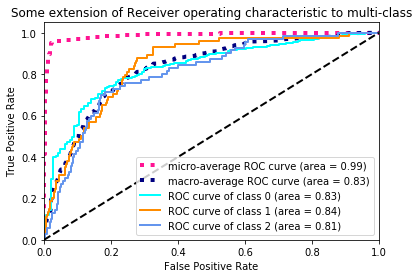

In [2]:
%matplotlib inline
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
 label='micro-average ROC curve (area = {0:0.2f})'
       ''.format(roc_auc["micro"]),
 color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
 label='macro-average ROC curve (area = {0:0.2f})'
       ''.format(roc_auc["macro"]),
 color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()